**3. NLP Pipeline**


**-Sentiment Analysis and Naive Bayes Classification**



**Loading Initial Libraries**

In [3]:
#libraries needed
import pandas as pd
import snscrape.modules.twitter as sntwitter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
# run once and comment it out to avoid it downloading multiple times
# nltk.download('stopwords') 
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('words')

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import gensim.downloader as api

import string
import re
import textblob
from textblob import TextBlob

from wordcloud import WordCloud, STOPWORDS
from emot.emo_unicode import UNICODE_EMOJI

porter = PorterStemmer()

lemmatizer = WordNetLemmatizer() 

from wordcloud import ImageColorGenerator
from PIL import Image

import warnings
%matplotlib inline


In [4]:
# Loading All the tweets 

df = pd.read_csv('data/tweets_all.csv')
df.head()

,Unnamed: 0,Date,source,location,tweet,num_of_likes,num_of_retweet
0,0,2022-11-01 23:59:59+00:00,Twitter for iPhone,NaN,@GHOSTofSURF @ThatEricAlper Always on spot! 🤪,0,0
1,1,2022-11-01 23:59:59+00:00,Twitter Web App,"Connecticut, USA",@GreenwaldEd @MadeInTheUSANJ @RepMTG If #GOP g...,2,1
2,2,2022-11-01 23:59:59+00:00,Twitter for Android,BBB 🫧,Let's vote! We have a chance to give them more...,0,0
3,3,2022-11-01 23:59:59+00:00,Twitter for iPhone,Red State USA,This is @KathyHochul NY. Get out and vote for ...,0,0
4,4,2022-11-01 23:59:59+00:00,Twitter for Android,"Minnesota, USA",@tophat595 @KihneSheila Thanks democrats! You ...,1,0


In [5]:
## Cleaning tweets for Naive Bayes
df.location.isna().sum()
df['location'] = df['location'].fillna('Unknown')

words = set(nltk.corpus.words.words())
eng_stopwords = []
with open('data/stopwords.txt','r') as file:    
      for line in file:         
          for sw in line.split():            
              eng_stopwords.append(sw)
emoji = list(UNICODE_EMOJI.keys())

def ProcessedTweets(text):
    text = text.lower()  #changing tweet text to small letters 
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", text).split()) # Removing @ and links
    text = re.sub(r'\@\w+|\#\w+|\d+', '', text) # removing repeating characters
    punct = str.maketrans('', '', string.punctuation+string.digits) # removing punctuation and numbers
    text = text.translate(punct)
    
    tokens = word_tokenize(text)  # tokenizing words and removing stop words from the tweet text
    filtered_words = [w for w in tokens if w not in eng_stopwords] #check for stopwords, remove them
    filtered_words = [w for w in filtered_words if w not in emoji] #remove emoji

    #also removed the words not in NLTK words dictionary of set(nltk.corpus.words.words())
    filtered_words1 = [w2 for w2 in filtered_words if w2 in words or w2 in {'democrats', 'dem', 'dems'}]
    #check for synonyms using wordnet 
    
    # lemmetizing words
    #lemmatizer = WordNetLemmatizer() 
    #lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
    #text = " ".join(lemma_words)
    
    text = " ".join(filtered_words1) #without wordnet and lemmatizing
    return text


**Sentiment Analysis**


In [6]:
def polarity(tweet):
    return TextBlob(tweet).sentiment.polarity

#decide the polarity of sentiments using this textblob function, difficult to do it for 20,000 tweets manually.
def sentimenttextblob(polarity):
    if polarity < 0:
        return -1 
        #"Negative"
    elif polarity == 0:
        return 0 
        #"Neutral"
    else:
        return 1 
        #"Positive" 

In [7]:
df['Processed_Tweets'] = df['tweet'].apply(ProcessedTweets)


In [8]:
# using the functions to get the polarity and sentiment
df['Polarity'] = df['Processed_Tweets'].apply(polarity)
df['Sentiment'] = df['Polarity'].apply(sentimenttextblob)
sentiments = df['Sentiment'].value_counts()
sentiments

 0    48588
 1    33625
-1    17792
Name: Sentiment, dtype: int64

([<matplotlib.patches.Wedge at 0x2cb22ca0f10>,
 [Text(-1.0907042043531696, -0.14270367411639862, 'Neutral'),
  Text(1.000399560870667, -0.4573846506057857, 'Positive'),
  Text(0.4124944055299731, 1.01972955503235, 'Negative')],
 [Text(-0.5949295660108197, -0.07783836769985379, '48.6%'),
  Text(0.5456724877476365, -0.2494825366940649, '33.6%'),
  Text(0.22499694847089438, 0.5562161209267362, '17.8%')])

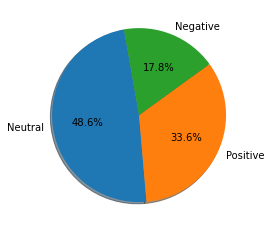

In [13]:
labels = ['Neutral', 'Positive', 'Negative']
fig1, ax1 = plt.subplots()
ax1.pie(sentiments, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100)

**CountVectorizer** creates a matrix in which each unique word is represented by a column of the matrix, and each text sample 
#from the document is a row in the matrix. The value of each cell is nothing but the count of the word in that particular 
#text sample
#how many times given words were found in the document.
#sparse matrix

#document[0]	0	0	0	1	1	0	0	1	0	1	0	1

#document[1]	0	0	1	0	2	0	1	0	0	0	0	1

#document[2]	1	1	0	1	1	1	0	1	1	0	1	0

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

In [16]:
#Initializing lists to be used in plotting later.
accuracy_ngrams = []
recall_ngrams = []
precion_ngrams = []
f1_ngrams = []

In [18]:
def naivebayesCV():
    #training and testing feature vectors
    
    for n in [1,2,3,5]:
        token = RegexpTokenizer(r'[a-zA-Z0-9]+')
        cv = CountVectorizer(stop_words='english',ngram_range = (n,n), tokenizer = token.tokenize)
        text_counts = cv.fit_transform(df['Processed_Tweets'])

        X_train, X_test, Y_train, Y_test = train_test_split(text_counts, df['Sentiment'], test_size=0.25, random_state=5)

        MNB = MultinomialNB()
        MNB.fit(X_train, Y_train)
        
        predicted = MNB.predict(X_test)
        
        accuracy_score = (metrics.accuracy_score(Y_test,predicted))
        accuracy_score = (round(accuracy_score,2))*100
        accuracy_ngrams.append(accuracy_score)

        precision = (metrics.precision_score(Y_test, predicted, average='macro'))
        precision = (round(precision,2))*100
        precion_ngrams.append(precision)

        recall = (metrics.recall_score(Y_test, predicted, average='macro'))
        recall = (round(recall,2))*100
        recall_ngrams.append(recall)

        f1 = (metrics.f1_score(Y_test, predicted, average='macro'))
        f1 = (round(f1,2))*100
        f1_ngrams.append(f1)

        #print("\n\nConfusion Matrix for k = {} is:\n".format(k))
        #print(confusion_mat)
        #print("\nClassification Report for k = {} is:\n".format(k))
        #print(class_report)
        print("Accuracy Score for ngrams = {0} is: {1}%".format(n,accuracy_score))
        print("Recall for ngrams = {0} is: {1}%".format(n,recall))
        print("Precision for ngrams = {0} is: {1}%".format(n,precision))
        print("F1-score for ngrams = {0} is: {1}%".format(n,f1))

In [19]:
naivebayesCV()

Accuracy Score for ngrams = 1 is: 86.0%
Recall for ngrams = 1 is: 84.0%
Precision for ngrams = 1 is: 84.0%
F1-score for ngrams = 1 is: 84.0%
Accuracy Score for ngrams = 2 is: 70.0%
Recall for ngrams = 2 is: 62.0%
Precision for ngrams = 2 is: 69.0%
F1-score for ngrams = 2 is: 64.0%
Accuracy Score for ngrams = 3 is: 55.00000000000001%
Recall for ngrams = 3 is: 41.0%
Precision for ngrams = 3 is: 67.0%
F1-score for ngrams = 3 is: 38.0%
Accuracy Score for ngrams = 5 is: 51.0%
Recall for ngrams = 5 is: 37.0%
Precision for ngrams = 5 is: 80.0%
F1-score for ngrams = 5 is: 28.999999999999996%


<function matplotlib.pyplot.show(close=None, block=None)>

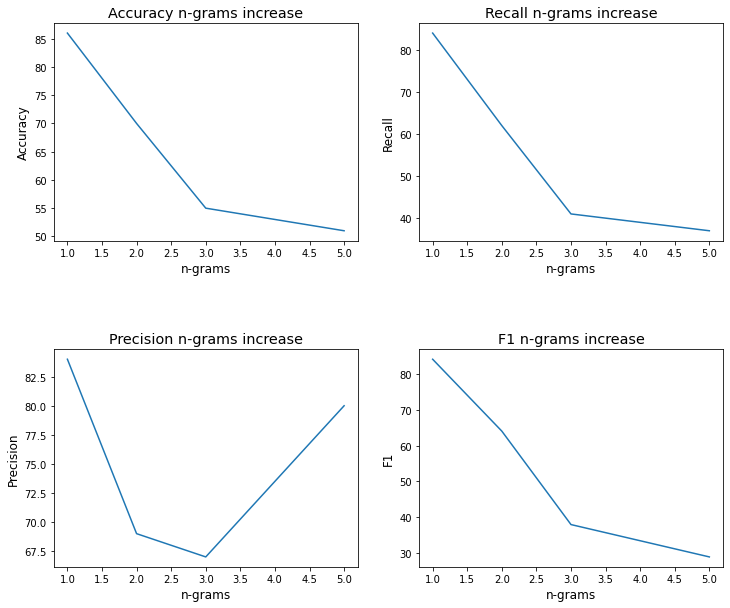

In [20]:
#print(accuracy_ngrams)
ngrams = [1,2,3,5] 

fig = plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.plot(ngrams, accuracy_ngrams)
plt.title("Accuracy n-grams increase",fontsize='x-large')
plt.xlabel("n-grams",fontsize='large')
plt.ylabel("Accuracy",fontsize='large')

plt.subplot(2,2,2)
plt.plot(ngrams,recall_ngrams)
plt.title("Recall n-grams increase",fontsize='x-large')
plt.xlabel("n-grams",fontsize='large')
plt.ylabel("Recall",fontsize='large')

plt.subplot(2,2,3)
plt.plot(ngrams,precion_ngrams)
plt.title("Precision n-grams increase",fontsize='x-large')
plt.xlabel("n-grams",fontsize='large')
plt.ylabel("Precision",fontsize='large')

plt.subplot(2,2,4)
plt.plot(ngrams,f1_ngrams)
plt.title("F1 n-grams increase",fontsize='x-large')
plt.xlabel("n-grams",fontsize='large')
plt.ylabel("F1",fontsize='large')

fig.subplots_adjust(hspace=0.5)

plt.show

In [21]:
accuracy_ngrams = []
recall_ngrams = []
precion_ngrams = []
f1_ngrams = []

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
def naivebayesTFIDF():
    #training and testing feature vectors
    
    for n in [1,2,3,5]:
        token = RegexpTokenizer(r'[a-zA-Z0-9]+')
        tfidf = TfidfVectorizer(stop_words='english',ngram_range = (n,n), analyzer='word', use_idf=True)#tokenizer = token.tokenize)
        text_count2 = tfidf.fit_transform(df['Processed_Tweets'])

        X_train, X_test, Y_train, Y_test = train_test_split(text_count2, df['Sentiment'], test_size=0.25, random_state=5)

        MNB = MultinomialNB()
        MNB.fit(X_train, Y_train)
        
        predicted = MNB.predict(X_test)
        
        accuracy_score = (metrics.accuracy_score(Y_test,predicted))
        accuracy_score = (round(accuracy_score,2))*100
        accuracy_ngrams.append(accuracy_score)

        precision = (metrics.precision_score(Y_test, predicted, average='macro'))
        precision = (round(precision,2))*100
        precion_ngrams.append(precision)

        recall = (metrics.recall_score(Y_test, predicted, average='macro'))
        recall = (round(recall,2))*100
        recall_ngrams.append(recall)

        f1 = (metrics.f1_score(Y_test, predicted, average='macro'))
        f1 = (round(f1,2))*100
        f1_ngrams.append(f1)

        #print("\n\nConfusion Matrix for k = {} is:\n".format(k))
        #print(confusion_mat)
        #print("\nClassification Report for k = {} is:\n".format(k))
        #print(class_report)
        print("Accuracy Score for ngrams = {0} is: {1}%".format(n,accuracy_score))
        print("Recall for ngrams = {0} is: {1}%".format(n,recall))
        print("Precision for ngrams = {0} is: {1}%".format(n,precision))
        print("F1-score for ngrams = {0} is: {1}%".format(n,f1))

In [23]:
naivebayesTFIDF()

Accuracy Score for ngrams = 1 is: 84.0%
Recall for ngrams = 1 is: 77.0%
Precision for ngrams = 1 is: 86.0%
F1-score for ngrams = 1 is: 79.0%
Accuracy Score for ngrams = 2 is: 63.0%
Recall for ngrams = 2 is: 50.0%
Precision for ngrams = 2 is: 79.0%
F1-score for ngrams = 2 is: 48.0%
Accuracy Score for ngrams = 3 is: 53.0%
Recall for ngrams = 3 is: 39.0%
Precision for ngrams = 3 is: 80.0%
F1-score for ngrams = 3 is: 33.0%
Accuracy Score for ngrams = 5 is: 51.0%
Recall for ngrams = 5 is: 36.0%
Precision for ngrams = 5 is: 81.0%
F1-score for ngrams = 5 is: 27.0%


[84.0, 63.0, 53.0, 51.0]


<function matplotlib.pyplot.show(close=None, block=None)>

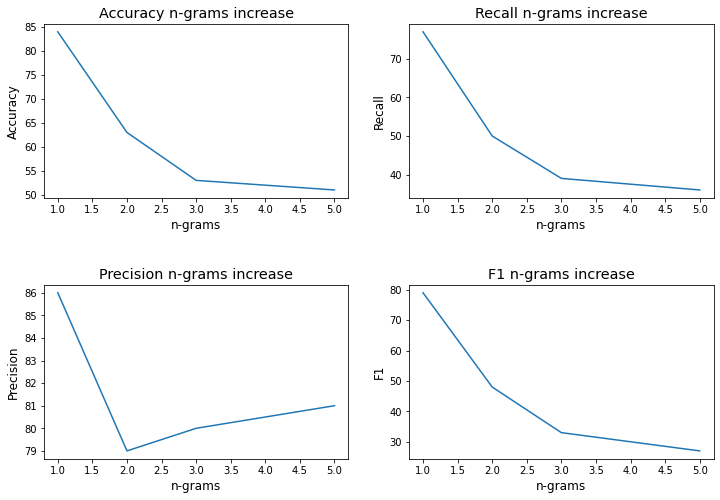

In [24]:
#print(accuracy_ngrams)
ngrams = [1,2,3,5] 

fig = plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(ngrams, accuracy_ngrams)
plt.title("Accuracy n-grams increase",fontsize='x-large')
plt.xlabel("n-grams",fontsize='large')
plt.ylabel("Accuracy",fontsize='large')

plt.subplot(2,2,2)
plt.plot(ngrams,recall_ngrams)
plt.title("Recall n-grams increase",fontsize='x-large')
plt.xlabel("n-grams",fontsize='large')
plt.ylabel("Recall",fontsize='large')

plt.subplot(2,2,3)
plt.plot(ngrams,precion_ngrams)
plt.title("Precision n-grams increase",fontsize='x-large')
plt.xlabel("n-grams",fontsize='large')
plt.ylabel("Precision",fontsize='large')

plt.subplot(2,2,4)
plt.plot(ngrams,f1_ngrams)
plt.title("F1 n-grams increase",fontsize='x-large')
plt.xlabel("n-grams",fontsize='large')
plt.ylabel("F1",fontsize='large')

fig.subplots_adjust(hspace=.5)

plt.show